# Hand digit classifier baseline
---
## Floating point precision weights

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from skimage import io

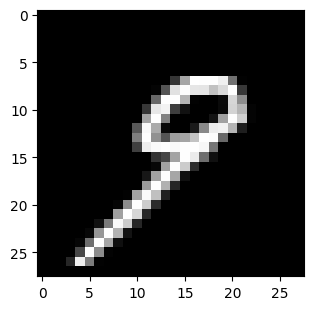

In [8]:
dataset = torchvision.datasets.MNIST(root="../", train=True, download=True)
sample, gt = dataset[501]
sample = np.array(sample)

fig = plt.figure()
io.imshow(sample)
fig.set_size_inches(3, 3)

##atti was here